# Introduction
The objective of this notebook is to provide a brief introduction to the SIR compartmental epidemiology model and then
demonstrate how to run the model for various parameters. Christian Hill's SIR epidemic model example in
[Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)
served as inspiration for some of the material presented herein.

# Background
The SIR [model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) is an epidemiological model that is useful for understanding how infectious disease in humans and animals evolve over time. It is a compartmental model
that divides the population into susceptible, infectious, and recovered groups. Given an initial population
distribution, it models the evolution of the number of people in each compartment over time.

\begin{equation*}
\large Susceptible\xrightarrow{\beta}Infectious\xrightarrow{\gamma}Recovered
\end{equation*}

where $\beta$ is the transmission rate and $\gamma$ is the recovery rate. Both are rates and therefore have units
expressed in per unit time. Alternatively, $1/\beta$ and $1/\gamma$ are expressed in time units such as days, weeks,
or months. For the purposes of the SIR model, the recovered group no longer affects disease transmission because
they are either recovered, deceased, or immune.

# Why?
When studying computational fluid dynamics in graduate school we sometimes found that our computed fluid flows failed
to capture all of the features observed in the lab. In these cases, we always reminded ourselves that "nature got the
flow right." Models do not always capture every phenomena. The aphorism
["All models are wrong, but some are useful"](https://en.wikipedia.org/wiki/All_models_are_wrong) holds true for the
SIR model. Populations are not constant. Transmission rates are not constant. That said, the model provides insights
into the complex interactions that occur in real transmission. It shows the interaction between
transmission rate and recovery rate and how they interact in ways that are not intuitive.

The SIR model is also important because it serves as the basis for other compartmental models. The simpler SI model can
be derived as a special case when the recovery time is infinite. The SIS model
can be used to model the common cold where recovery does not confer immunity. The SIRS model is an extension where
immunity wanes over time like the flu. Armed with the information below these models will be within reach.

# The SIR Model

The SIR model starts with the assumption that the entire population can be divided into Susceptible, Infectious, and
Recovered groups denoted by $S$, $I$, and $R$ respectively. The total population, denoted by $N$, is assumed to
remain constant. These values are related as follows:

\begin{equation*}
S(t) + I(t) + R(t) = N = {\text{constant}}
\end{equation*}

Our goal is to model how the number of people in each group change over time. Taking the derivative with respect to
time yields:

\begin{equation*}
\frac{dS}{dt} + \frac{dI}{dt} +\frac{dR}{dt} = 0
\end{equation*}

The rate of change must net out to zero. If one bucket is draining another bucket must be filling up. The system of ordinary differential equations governing how the population in each bucket grow and shrinks is given by:

\begin{aligned}
{\frac {dS}{dt}} & = -{\frac {\beta SI}{N}},\\
{\frac {dI}{dt}} & = {\frac {\beta SI}{N}}-\gamma I,\\
{\frac {dR}{dt}} & = \gamma I,
\end{aligned}

It is important to remember that the variables $S$, $I$, and $R$ are always positive and may evolve with time while
$N$, $\beta$, and $\gamma$ are all positive constants. Given an initial population for each compartment, we can evolve
the populations in each bucket over time. Note that $S$ may never grow because $\beta$, $I$, $S$, and $N$ are always
positive which ensures that the rate is negative. Likewise, the population in the recovered compartment, $R$, may never decrease because both $\gamma$ and $I$
are positive ensuring that the growth rate is always postive. By contrast, the infectious population may grow or shrink depending on relative size of the two terms.

We can generalize this model to populations of any size by thinking in terms of
percent susceptible, infected and recovered as follows:

\begin{aligned}
s(t) & = {\frac {S(t)}{N}} \\
i(t) & = {\frac {I(t)}{N}} \\
r(t) & = {\frac {R(t)}{N}} \\
\end{aligned}

Substitution $S=sN$, $I=iN$, and $R=rN$ into the original equations yields:

\begin{equation*}
s(t) + i(t) + r(t) = 1
\end{equation*}

\begin{equation*}
\frac{ds}{dt} + \frac{di}{dt} +\frac{dr}{dt} = 0
\end{equation*}

\begin{aligned}
{\frac {ds}{dt}} & =-\beta si,\\
{\frac {di}{dt}} & = \beta si - \gamma i,\\
{\frac {dr}{dt}} & = \gamma i,
\end{aligned}

Note that the equations above are independent of populations size $N$. Time for a quick diversion: what if the 
recovery rate $\gamma$ is zero?

# The SI Model

When $\gamma$ is zero, there is no recovery so $r=0$ and $dr/dt=0$. This is the zombie model
(think World War Z or The Walking Dead). Alternatively, this model might describe meme transmission. Intially, only a
few people on reddit are spreading the meme but eventually everybody is repeating it.
The SIR model reduces to the SI model, viz.

\begin{equation*}
s(t) + i(t) = 1
\end{equation*}

\begin{equation*}
\frac{ds}{dt} + \frac{di}{dt} = 0
\end{equation*}

\begin{aligned}
{\frac {ds}{dt}} & = -\beta si,\\
{\frac {di}{dt}} & =  \beta si,
\end{aligned}

If we substitute $i = 1 - s$ into the equation for $di/dt$ we get

\begin{equation*}
\frac{di}{dt} = \beta i (1-i)
\end{equation*}

Dividing through by $\beta$ yields

\begin{equation*}
\frac{1}{\beta}\frac{di}{dt} = i - i^2
\end{equation*}

Some may recognize this as the [logistic differential equation](https://brilliant.org/wiki/logistic-differential-equations/) whose solution is the logistic function, namely:

\begin{equation*}
i(t) = \frac{i_0}{i_0 + s_0 e^{-\beta t}}
\end{equation*}

where $i_0$ and $s_0$ are the values of $s$ and $i$ at $t=0$. The logistic function is an example of a sigmoid curve and has applications in neural networks as an activation function among others. When $t=0$, $e^{-\beta t}=1$ and $i(0)=i_0$ (remember that $s_0 + i_0 = 1$). As $t \rightarrow \infty$, $e^{-\beta t} \rightarrow 0$ and $i(t) \rightarrow 1$. Finally, note that as $t \rightarrow -\infty$, $i \rightarrow 0$. Let's plot the solution:

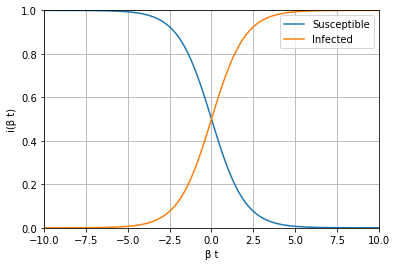

In [12]:
import matplotlib.pyplot as plt
import numpy as np

i_0 = 0.5
s_0 = 1 - i_0
betat = np.linspace(-10, 10, 200)
plt.plot(betat, 1 - i_0 / (i_0 + s_0 * np.exp(-betat)), label='Susceptible')
plt.plot(betat, 0 + i_0 / (i_0 + s_0 * np.exp(-betat)), label='Infected')
plt.xlabel('\u03B2 t')
plt.ylabel('i(\u03B2 t)')
plt.xlim((-10,10))
plt.ylim((0,1))
plt.grid()
plt.legend()
plt.show()

The plot above shows plots $i$ as a function of $\beta t$ for $i_0 = 0.5$. The shape of the plot is the same for any value of $i_0$ it simply shifts from left to right. Also note that we never needed to specify $\beta$ because $i$ is expressed in terms of $\beta t$. It is interesting to note that $\beta t$ is dimensionless since both $t$ and $1/\beta$ have units of time. This observation will be useful when we revisit the SIR model. 

# The basic reproduction ratio $R_0$

We have already scaled $s$, $i$ and $r$ by the total population size $N$. We will now scale time using the recovery
rate $\gamma$. Dividing through our previous equations by $\gamma$ and introducing $\tau=\gamma t$ as our
dimensionless time parameter yields

\begin{equation*}
s(\tau) + i(\tau) + r(\tau) = 1
\end{equation*}

\begin{equation*}
\frac{ds}{d\tau} + \frac{di}{d\tau} +\frac{dr}{d\tau} = 0
\end{equation*}

\begin{aligned}
{\frac {ds}{d\tau}} & =-R_0 si,\\
{\frac {di}{d\tau}} & = R_0 si - i,\\
{\frac {dr}{d\tau}} & = i,
\end{aligned}

where we have introduced $R_0 = \beta/\gamma $ as the [basic reproduction ratio](https://en.wikipedia.org/wiki/Basic_reproduction_number) which is the ratio of the transmission rate to the recovery rate. $R_0$ can be thought of as the average number of secondary cases arising from an average primary case in an entirely susceptible population. If $R_0$ is greater than 1 it means that the rate of infection may instantaneously outpace the rate of recovery resulting in an outbreak. We now have the SIR model with a single parameter, $R_0$. The constants $N$, $\beta$, and $\gamma$ scale the solution but do not change the evolution of the compartments. Let us now solve these equations to determine the time evolution of the populations.

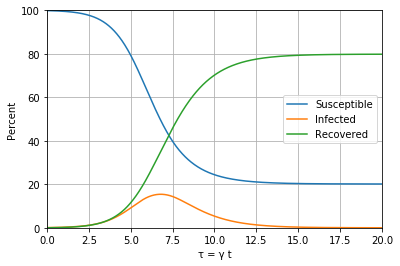

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# The SIR model differential equations.
def sir_model(t, y):
    # basic reproduction ratio
    R_0 = 2

    s, i, r = y
    dsdtau = -R_0 * s * i
    didtau =  R_0 * s * i - i
    drdtau =  i
    return dsdtau, didtau, drdtau


# Initial number of infected and recovered individuals
# Everyone else is susceptible to infection initially.
r_initial = 0
i_initial = 0.001
s_initial = 1 - i_initial - r_initial

# Integrate the SIR equations over the time
# ivp means initial value problem (as opposed to a boundary value problem)
t_initial = 0
t_final = 20
sol = solve_ivp(sir_model, (t_initial, t_final), (s_initial, i_initial, r_initial),
                t_eval=np.linspace(t_initial, t_final, 1000))
s, i, r = sol.y

plt.plot(sol.t, 100*s, label='Susceptible')
plt.plot(sol.t, 100*i, label='Infected')
plt.plot(sol.t, 100*r, label='Recovered')
plt.xlabel("\u03C4 = \u03B3 t")
plt.ylabel('Percent')
plt.xlim((t_initial, t_final))
plt.ylim((0,100))
plt.grid()
plt.legend()
plt.show()

# What is solve_ivp actually doing?

The SIR model is an initial value problem. We choose initial values for $s_0$ (close to 1), $i_0$ (close to 0), and $r_0$ (the initial recovered population not to be confused with $R_0$) and want to understand "the next value" for each. We can think of the slope as the difference between successive values of $s$, $i$, and $r$ for short time steps. If we know the all three values at time step $n$ we can approximate the values at time $n+1$ as follows

\begin{aligned}
{\frac {ds}{d\tau}} & \approx {\frac {\Delta s}{\Delta\tau}} = {\frac {s_{n+1} - s_n}{\Delta\tau}} = - R_0 s_n i_n \\
{\frac {di}{d\tau}} & \approx {\frac {\Delta i}{\Delta\tau}} = {\frac {i_{n+1} - i_n}{\Delta\tau}} = R_0 s_n i_n - i_n  \\
{\frac {dr}{d\tau}} & \approx {\frac {\Delta r}{\Delta\tau}} = {\frac {r_{n+1} - r_n}{\Delta\tau}} = i_n \\
\end{aligned}

where $\Delta\tau$ is known small time step of our choosing. Rearranging and solving for the $n+1$ terms yields

\begin{aligned}
s_{n+1} & = s_n - \Delta\tau R_0 s_n i_n   \\
i_{n+1} & = i_n + \Delta\tau (R_0 s_n i_n - i_n)   \\
r_{n+1} & = r_n + \Delta\tau i_n \\
\end{aligned}

Note that the difference equations listed above are quite simple to solve using any programming language or Excel. In scientific computing, this technique for estimating the next time step is called the forward Euler method because we chose to evaluate the slope using $s_n$ and $i_n$. There are other choices that we could have made. The Adams–Bashforth method determines the next value using a weighted average of the two previous values. By default, solve_ivp uses the Runge-Kutta method but the concept is the same.

# The SIS Model

The common cold and influenza are examples of infections that do not give immunity upon recovery from infection. Rather than recovering, infectious individuals become susceptible again, viz.

\begin{equation*}
\large Susceptible\xrightarrow{\beta}Infectious\xrightarrow{\gamma}Susceptible
\end{equation*}

Note that the susceptible compartment now decreases as indivuals become infected and increases as they recover. This differs from the SIR model where the susceptible compartment may never increase. The SIS model in dimensionless form is:

\begin{equation*}
s(\tau) + i(\tau) = 1
\end{equation*}

\begin{equation*}
\frac{ds}{d\tau} + \frac{di}{d\tau} = 0
\end{equation*}

\begin{aligned}
{\frac {ds}{d\tau}} & =-R_0 is + i,\\
{\frac {di}{d\tau}} & = R_0 is - i,
\end{aligned}

If we substitue $i = 1 - s$ into the equation for $di/d\tau$ we get

\begin{equation*}
\frac{di}{d\tau} = (R_0 - 1) i - R_0 i^2
\end{equation*}

This is once again the [logistic differential equation](https://brilliant.org/wiki/logistic-differential-equations/)
that we encountered with the SI model but with different coefficients. The solution for the SIS model is:

\begin{equation*}
i(\tau) = \frac{i_0 i_\infty}{i_0 + (i_\infty - i_0) e^{- (R_0 - 1) \tau}}
\end{equation*}

where $i_0$ is the value of $i$ at $\tau=0$ and $i_\infty$ is a constant that depends only on $R_0$, namely:

\begin{equation*}
i_\infty = 1 - \frac{1}{R_0}
\end{equation*}

When $t=0$, $e^{- (R_0 - 1) \tau}=1$ and we can confirm that $i(0)=i_0$. As $t \rightarrow \infty$, the behavior of the solution depends on the value of $R_0$. When $R_0 < 1$, $e^{- (R_0 - 1) \tau} \rightarrow \infty$ and $i(t) \rightarrow 0$. When $R_0 = 1$, $e^{- (R_0 - 1) \tau} = 1$ and $i(t) = i_0$, remaining constant. This is the balancing point where the number of infectious individuals does not increase or decrease. Finally, when $R_0 > 1$, $e^{- (R_0 - 1) \tau} \rightarrow 0$ and $i(t) \rightarrow i_\infty$. 

Let's visualize these results. First, we will plot $i$ and $s$ as a function of $\tau$ for $R_0 = 2.5$.

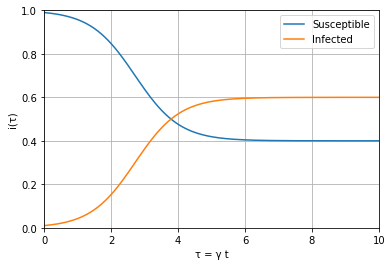

In [27]:
import matplotlib.pyplot as plt
import numpy as np


def sis_model_infectious(tau, i_0, R_0):
    i_infty = 1.0 - (1.0 / R_0)
    exponent = - (R_0 - 1) * tau
    
    return i_0 * i_infty / (i_0 + (i_infty - i_0) * np.exp(exponent))


i_0 = 0.01
s_0 = 1 - i_0
R_0 = 2.5
t_initial = 0
t_final = 10
tau = np.linspace(t_initial, t_final, 200)
plt.plot(tau, 1 - sis_model_infectious(tau, i_0, R_0), label='Susceptible')
plt.plot(tau, 0 + sis_model_infectious(tau, i_0, R_0), label='Infected')
plt.xlabel("\u03C4 = \u03B3 t")
plt.ylabel('i(\u03C4)')
plt.xlim((t_initial,t_final))
plt.ylim((0,1))
plt.grid()
plt.legend()
plt.show()

Second, we will plot the endemic steady state $i_\infty$ as a function of $R_0$, viz:

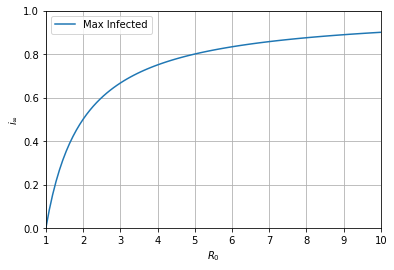

In [6]:
import matplotlib.pyplot as plt
import numpy as np

R_0 = np.linspace(1, 10, 100)
plt.plot(R_0, 1 - 1/R_0, label='Max Infected')
plt.xlabel(r"$R_0$")
plt.ylabel(r"$i_\infty$")
plt.xlim((1,10))
plt.ylim((0,1))
plt.grid()
plt.legend()
plt.show()

To be clear, when the model reaches an endemic steady state it does not mean that there are no longer new infections. Rather it means that for every new infection introduced another infection subsides. What can be observed in the plot above is that the endemic population is highly sensitive to $R_0$. When $R_0$ is between one and two, small changes in $R_0$ result in large increases in the endemic steady state. 

# The SIS Model: Phase Portrait

\begin{equation*}
\frac{di}{d\tau} = (R_0 - 1) i - R_0 i^2 = R_0 i \left[ \left(1-\frac{1}{R_0}\right) -i \right] = R_0 i\left(i_\infty -i \right)
\end{equation*}


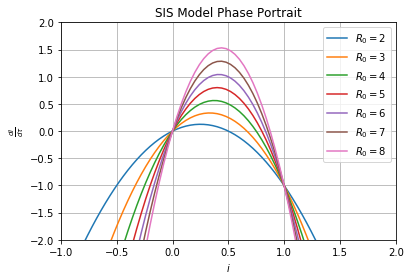

In [32]:
import matplotlib.pyplot as plt
import numpy as np

i = np.linspace(-2, 2, 101)
R_0 = 5
for R_0 in range(2,9):
    plt.plot(i, (R_0-1)*i - R_0*i*i, label=r"$R_0=%s$" % R_0)
plt.title('SIS Model Phase Portrait')
plt.xlabel(r"$i$")
plt.ylabel(r"$\frac{di}{d\tau}$")
plt.xlim((-1,2))
plt.ylim((-2,2))
plt.grid()
plt.legend()
plt.show()